<a href="https://colab.research.google.com/github/cherukRahul/final-project-AIR-POLLUTION-FORECASTING-/blob/main/Copy_of_Rahul_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1️⃣ Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

#  Load Dataset
file_path = "city_day.csv"
df = pd.read_csv(file_path)

#  Basic Info
print("✅ Data Loaded Successfully!")
print(f"Shape: {df.shape}")
print("\nColumns:", df.columns.tolist())
df.head()

#  Data Summary
print("\nMissing Values per Column:\n", df.isnull().sum())
print("\nUnique Cities:", df['City'].nunique())

#  Convert Dates and Sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['City', 'Date']).reset_index(drop=True)

#  Handle Missing Values (Forward Fill by City)
df = df.groupby('City').apply(lambda x: x.fillna(method='ffill')).reset_index(drop=True)

✅ Data Loaded Successfully!
Shape: (29531, 16)

Columns: ['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']

Missing Values per Column:
 City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64

Unique Cities: 26


In [2]:
# Step 3: Exploratory Data Analysis (EDA)

# 3.1 Overview of the Dataset
print(df.info())
print(df.describe())

# 3.2 Missing Values Check
print(df.isnull().sum())

# Print the first few columns (say, first 3 columns) for the first few rows
print(df.iloc[:, :].head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        29531 non-null  object        
 1   Date        29531 non-null  datetime64[ns]
 2   PM2.5       27109 non-null  float64       
 3   PM10        20050 non-null  float64       
 4   NO          28352 non-null  float64       
 5   NO2         28351 non-null  float64       
 6   NOx         27968 non-null  float64       
 7   NH3         21139 non-null  float64       
 8   CO          29525 non-null  float64       
 9   SO2         28399 non-null  float64       
 10  O3          28269 non-null  float64       
 11  Benzene     26385 non-null  float64       
 12  Toluene     25100 non-null  float64       
 13  Xylene      14491 non-null  float64       
 14  AQI         27690 non-null  float64       
 15  AQI_Bucket  27690 non-null  object        
dtypes: datetime64[ns](1), 

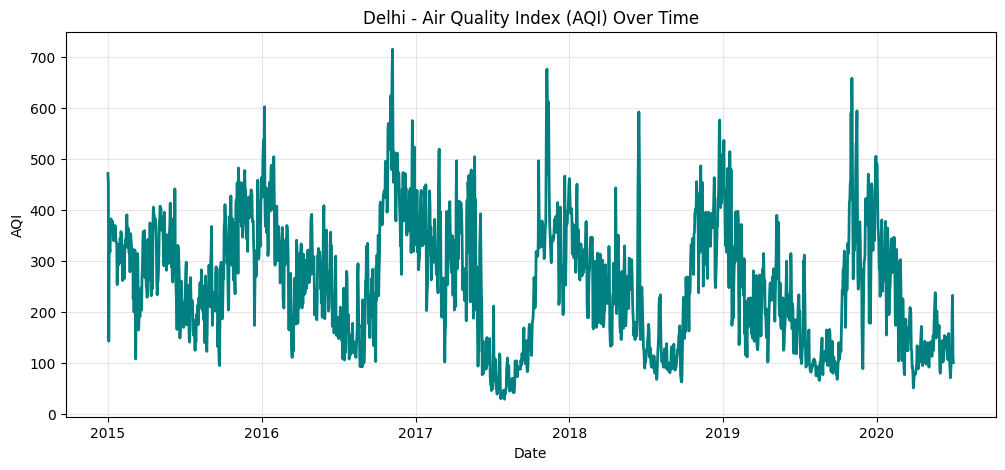

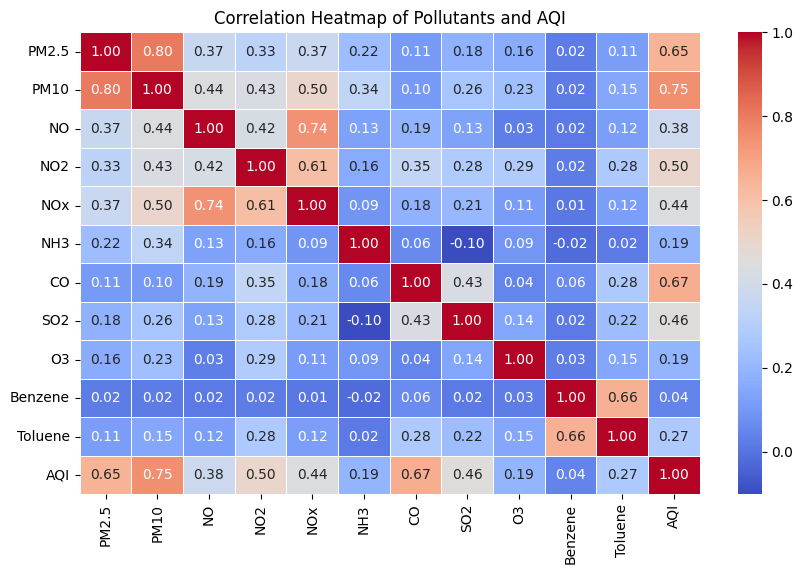

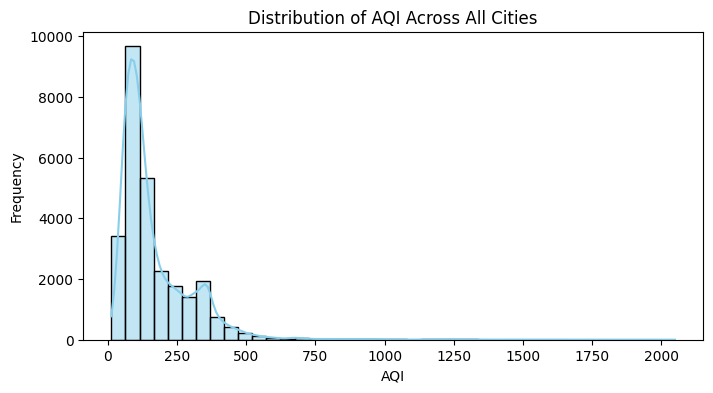

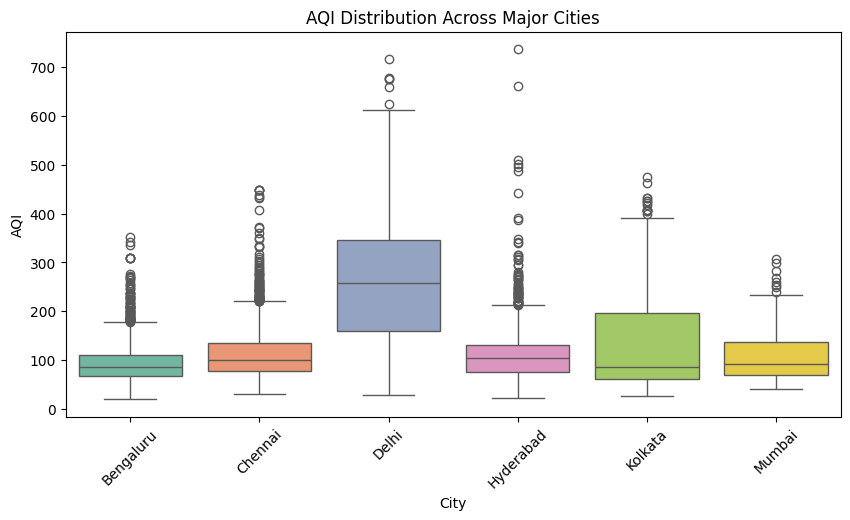

 
================ RANDOM FOREST ( FIXED) ================
 
Random Forest RMSE: 27.68
Random Forest MAE : 20.59


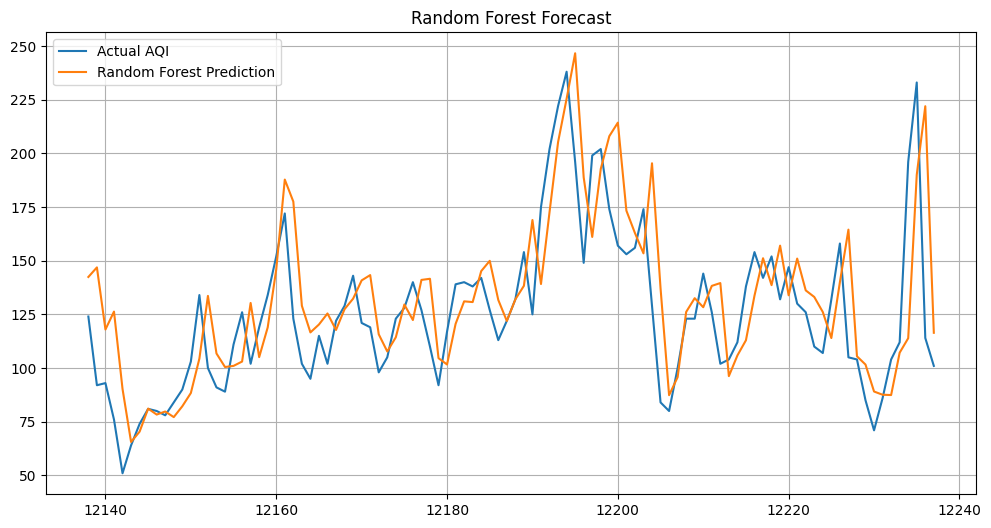


================ XGBOOST ================

XGBoost RMSE: 28.27
XGBoost MAE : 20.80


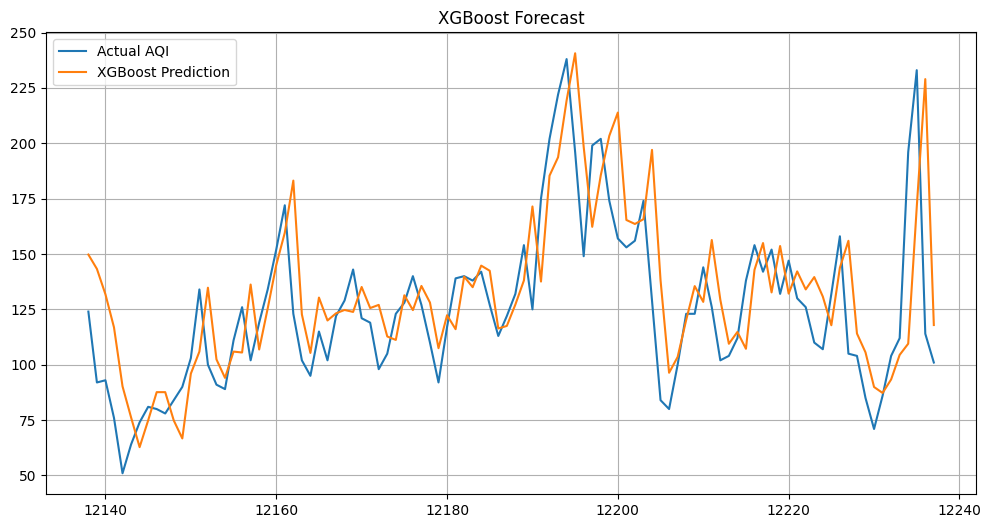

In [24]:

# AQI Trend Over Time (for one city)
city = 'Delhi'
city_df = df[df['City'] == city]


plt.figure(figsize=(12, 5))
plt.plot(city_df['Date'], city_df['AQI'], color='teal', linewidth=2)
plt.title(f'{city} - Air Quality Index (AQI) Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.grid(alpha=0.3)
plt.show()

# Correlation Heatmap (Air Pollutants vs AQI)

cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'AQI']
corr = df[cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Pollutants and AQI')
plt.show()

#AQI Distribution (Histogram + KDE)
plt.figure(figsize=(8, 4))
sns.histplot(df['AQI'], bins=40, kde=True, color='skyblue')
plt.title('Distribution of AQI Across All Cities')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()


#Comparison of AQI Levels Across Major Cities (Box Plot)
major_cities = ['Delhi', 'Mumbai', 'Kolkata', 'Chennai', 'Bengaluru', 'Hyderabad']
subset = df[df['City'].isin(major_cities)]

plt.figure(figsize=(10, 5))
sns.boxplot(data=subset, x='City', y='AQI', palette='Set2')
plt.title('AQI Distribution Across Major Cities')
plt.xticks(rotation=45)
plt.show()



print (" \n================ RANDOM FOREST ( FIXED) ================\n " )

def create_lags(df, lag=7):
 df = df.copy()
 for i in range(1, lag+1):
    df[f"lag_{i}"] = df["AQI"].shift(i)
 return df.dropna()


# Only keep AQI column before creating lags
aqi_only_df = city_df[["AQI"]]
lag_df = create_lags(aqi_only_df, lag=7)
# Input features (all lag columns)
X = lag_df.drop("AQI", axis=1)

# Target
y = lag_df["AQI"]

# Split using same 100-step rule
x_train = X.iloc[:-100]
X_test = X.iloc[-100:]

y_train = y.iloc[:-100]
y_test = y.iloc[-100:]

# Import model
from sklearn.ensemble import RandomForestRegressor


# Train model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(x_train, y_train)

# Predict
rf_pred = rf.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))
mae_rf = mean_absolute_error(y_test, rf_pred)


print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest MAE : {mae_rf:.2f}")

# Plot results
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label="Actual AQI")
plt.plot(y_test.index, rf_pred, label="Random Forest Prediction")
plt.legend()
plt.title("Random Forest Forecast")
plt.grid()
plt.show()

#xgboost

print("\n================ XGBOOST ================\n")
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5)

from sklearn.model_selection import train_test_split
xgb.fit(x_train,y_train)

xgb_pred = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))
mae_xgb = mean_absolute_error(y_test, xgb_pred)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost MAE : {mae_xgb:.2f}")

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label="Actual AQI")
plt.plot(y_test.index, xgb_pred, label="XGBoost Prediction")
plt.legend()
plt.title("XGBoost Forecast")
plt.grid()
plt.show()


